# Segmentation of Sentinel 2 images with TFRecords and ML Engine

**Eager Execution**

TensorFlow's [eager execution](https://www.tensorflow.org/guide/eager) is an imperative programming environment that evaluates operations immediately, without building graphs: operations return concrete values instead of constructing a computational graph to run later. This makes it easy to get started with TensorFlow and debug models, and it reduces boilerplate as well.

In [19]:
import tensorflow as tf
print(tf.__version__)

tf.enable_eager_execution()

1.15.0


**Set environment**

In [2]:
import ee
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

**Initialize the Earth Engine client**

In [4]:
ee.Initialize()

### Export `.tfrecor` files to Google Cloud Storage

In [ ]:
from preprocess.ee_dataset_acquisition_TFRecord_ML_Engine import ee_dataset

In [ ]:
# Central position of (AOIs)
points = [[-120.7224, 37.3872], [-112.6799, 42.9816], [-89.7649, 35.8764], 
          [-96.0181, 41.2412], [-115.473, 46.861], [-103.9803, 47.9713], 
          [-96.9217, 32.8958], [-82.986, 40.019], [-90.347, 38.668], 
          [-110.6947, 37.4568], [-101.8889, 33.5527], [-92.621, 33.417],
          [-80.352, 38.628], [-104.752, 43.972], [-110.92, 37.18]]

# Start and stop of time series
startDate = ee.Date('2016-01-01')
stopDate  = ee.Date('2016-12-31')
# Scale in meters
scale = 10
# Buffer
buffer = 40000

In [ ]:
dataset = ee_dataset(points = points, buffer = buffer, patch_size= (128,128), startDate = startDate, stopDate = stopDate, scale = scale, file_name='dataset_AOI', collections = ['Sentinel2','CroplandDataLayers'])
dataset.export_toCloudStorage()

### Reading a single record from TFRecord files

In [5]:
bucket_name = 'skydipper_materials'
dataset_path = 'gs://'+bucket_name+'/'+'gee_data_TFRecords/dataset_AOI_03.tfrecord.gz'

In [7]:
options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)
record_iterator = tf.python_io.tf_record_iterator(path=dataset_path, options=options)

for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    print(example)
    # Exit after 1 iteration as this is purely demonstrative.
    break

features {
  feature {
    key: "cropland"
    value {
      bytes_list {
        value: "\003\003\003\003\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\001\001\001\001\001\001\001\001\001\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\003\003\003\003\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\001\0

### Recover the images from the TFRecord file

In [8]:
image_dataset = tf.data.TFRecordDataset(dataset_path, compression_type='GZIP')

def parse_function(proto):
    
    # Define your tfrecord 
    bands_input = ['vis-blue', 'vis-green', 'vis-red']
    columns_input = [tf.io.FixedLenFeature([], tf.string) for i in bands_input]
    
    bands_output = ['cropland']
    columns_output = [tf.io.FixedLenFeature([], tf.string) for i in bands_output]
    
    bands = bands_input + bands_output
    columns = columns_input + columns_output
    features = dict(zip(bands, columns))
    
    # Load one example
    parsed_features = tf.parse_single_example(proto, features)
    
    # Decode images (turn your saved image string into an array) and reshape them
    for i in bands_input:
        parsed_features[i] = tf.decode_raw(parsed_features[i], tf.uint8)
        parsed_features[i] = tf.reshape(parsed_features[i], [128, 128, 1])
    
    # # Merge the input bands into a sigle image
    parsed_features['image'] = tf.concat([parsed_features[i] for i in bands_input], axis=2)
    
    # Normalize image
    parsed_features['image'] = tf.divide(parsed_features['image'], 255)
    
    ## Decode image (turn your saved image string into an array) 
    parsed_features['label'] = tf.decode_raw(parsed_features['cropland'], tf.uint8)
    #
    ## Reshape image
    parsed_features['label'] = tf.reshape(parsed_features['label'], [128, 128])
    #
    ## Create a one hot array for your labels
    parsed_features['label'] = tf.one_hot(parsed_features['label'], 4)
    
    return parsed_features

dataset = image_dataset.map(parse_function)
dataset

<DatasetV1Adapter shapes: {cropland: (), vis-blue: (128, 128, 1), vis-green: (128, 128, 1), vis-red: (128, 128, 1), image: (128, 128, 3), label: (128, 128, 4)}, types: {cropland: tf.string, vis-blue: tf.uint8, vis-green: tf.uint8, vis-red: tf.uint8, image: tf.float32, label: tf.float32}>

**Display channels**

In [9]:
def display_channels(data, nChannels, titles = False):
    if nChannels == 1:
        plt.figure(figsize=(5,5))
        plt.imshow(data[:,:,0])
        if titles:
            plt.title(titles[0])
    else:
        fig, axs = plt.subplots(nrows=1, ncols=nChannels, figsize=(5*nChannels,5))
        for i in range(nChannels):
            ax = axs[i]
            ax.imshow(data[:,:,i])
            if titles:
                ax.set_title(titles[i])

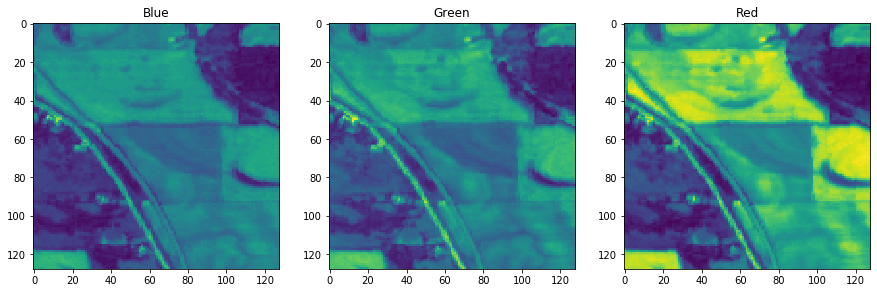

In [10]:
for image_features in dataset:
    image = image_features['image'].numpy()
    
    break
    
display_channels(image, image.shape[2], titles=['Blue', 'Green', 'Red'])

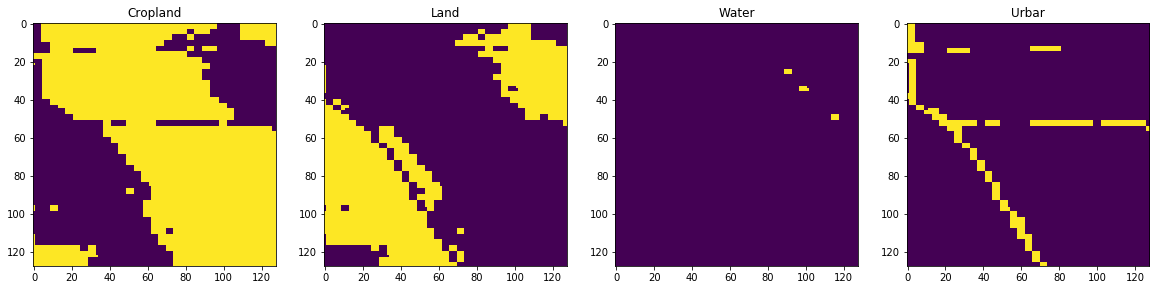

In [11]:
for image_features in dataset:
    image = image_features['label'].numpy()
    
    break
    
display_channels(image, image.shape[2], titles=['Cropland', 'Land', 'Water', 'Urbar'])

### Get file paths from Google Cloud Storage

In [ ]:
from google.cloud import storage

def get_files(bucketname, privatekey_path, folder, file_type):
    client = storage.Client.from_service_account_json(privatekey_path)
    bucket = client.get_bucket(bucketname)

    ## Get file list
    filelist = []
    blobs = bucket.list_blobs(prefix=folder )
    for blob in blobs:
        filelist.append(blob.name) 
    
    files = [i for i in filelist if file_type in i]
    files = ['gs://'+bucketname+'/'+i for i in files]
    
    return files

In [ ]:
bucketname = 'skydipper_materials'
privatekey_path = "/Users/ikersanchez/Vizzuality/Keys/Skydipper/skydipper-562ee3e31bb2.json"
folder = 'gee_data_TFRecords/'
file_type = 'tfrecord.gz'

files = get_files(bucketname, privatekey_path, folder, file_type)

In [ ]:
nTrain = int(len(files)*0.75)
nValidation = int(len(files)*0.25)
training_filepath = files[:nTrain]
validation_filepath = files[nTrain:nTrain+nValidation]

In [ ]:
# Dimensions
options = tf.io.TFRecordOptions(tf.compat.v1.io.TFRecordCompressionType.GZIP)
num_train_examples = sum(sum(1 for _ in tf.compat.v1.io.tf_record_iterator(filepath, options=options)) for filepath in training_filepath)
num_eval_examples = sum(sum(1 for _ in tf.compat.v1.io.tf_record_iterator(filepath, options=options)) for filepath in validation_filepath)

print('Train samples:', num_train_examples)
print('Validation samples:', num_eval_examples)

### Training in AI Platform

In [ ]:
PROJECT_ID = "skydipper-196010" 
! gcloud config set project $PROJECT_ID

In [ ]:
BUCKET_NAME = "skydipper_materials" #@param {type:"string"}
REGION = "us-west1"#europe-west1 #@param {type:"string"}

In [ ]:
! gsutil ls -al gs://$BUCKET_NAME

In [ ]:
# Set the working directory to the sample code directory
%cd AI_Platform/Segmentation

In [ ]:
# `ls` shows the working directory's contents. The `p` flag adds trailing 
# slashes to subdirectory names. The `R` flag lists subdirectories recursively.
! ls -pR

**Train your model locally**

In [ ]:
# Explicitly tell `gcloud ai-platform local train` to use Python 3 
! gcloud config set ml_engine/local_python $(which python3)

# This is similar to `python -m trainer.task --job-dir local-training-output`
# but it better replicates the AI Platform environment, especially for
# distributed training (not applicable here).
! gcloud ai-platform local train \
  --package-path trainer \
  --module-name trainer.task \
  --job-dir local-training-output \
  -- \
  --num-epochs 1 \
  --batch-size 32 \
  --model-name deepvel

In [ ]:
model = deepvel(inputShape=(256, 256, 3), nClasses=4)

**Train your model using AI Platform**

In [ ]:
JOB_NAME = 'segnet_v16'
JOB_DIR = 'gs://' + BUCKET_NAME + '/segmentation'

In [ ]:
! gcloud ai-platform jobs submit training $JOB_NAME \
  --package-path trainer/ \
  --module-name trainer.task \
  --region $REGION \
  --config config.yaml \
  --python-version 3.5 \
  --runtime-version 1.13 \
  --job-dir $JOB_DIR \
  --stream-logs \
  -- \
  --num-epochs 20 \
  --batch-size 16 \
  --model-name segnet

In [ ]:
!gcloud ai-platform jobs cancel $JOB_NAME

### Predictions in AI Platform

**Create model and version resources in AI Platform**

In [ ]:
MODEL_NAME = "segnet"
REGION = "europe-west1"

In [ ]:
! gcloud ai-platform models create $MODEL_NAME \
  --regions $REGION

In [ ]:
MODEL_VERSION = "v2"

In [ ]:
# Get a list of directories in the `keras_export` parent directory
KERAS_EXPORT_DIRS = ! gsutil ls $JOB_DIR/keras_export/

# Pick the directory with the latest timestamp, in case you've trained
# multiple times
SAVED_MODEL_PATH = KERAS_EXPORT_DIRS[-1]

# Create model version based on that SavedModel directory
! gcloud ai-platform versions create $MODEL_VERSION \
  --model $MODEL_NAME \
  --runtime-version 1.13 \
  --python-version 3.5 \
  --framework tensorflow \
  --origin $SAVED_MODEL_PATH

**Read input data for prediction**

In [ ]:
bucket_name = 'skydipper_materials'
dataset_path = 'gs://'+bucket_name+'/'+'gee_data_TFRecords/dataset_AOI_00.tfrecord.gz'

options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)
num_examples = sum(1 for _ in tf.python_io.tf_record_iterator(dataset_path, options=options))

print('Number of images:', num_examples)

image_dataset = tf.data.TFRecordDataset(dataset_path, compression_type='GZIP')
dataset = image_dataset.map(parse_function)

In [ ]:
import numpy as np
images = np.zeros((num_examples, 128, 128, 3))
for n, image_features in enumerate(dataset):
    images[n,:,:,:] = image_features['image'].numpy()
    
display_channels(images[44,:,:,:], images.shape[3], titles=['Blue', 'Green', 'Red'])

In [ ]:
labels = np.zeros((num_examples, 128, 128, 4))
for n, image_features in enumerate(dataset):
    labels[n,:,:,:] = image_features['label'].numpy()
    
display_channels(labels[44,:,:,:], labels.shape[3], titles=['Cropland', 'Land', 'Water', 'Urbar'])

In [ ]:
display_channels(images[400,:,:,:], images.shape[3], titles=['Blue', 'Green', 'Red'])

In [ ]:
display_channels(labels[400,:,:,:], labels.shape[3], titles=['Cropland', 'Land', 'Water', 'Urbar'])

**Requesting predictions**

In [ ]:
from google.oauth2 import service_account
import googleapiclient

def predict_json(project, model, instances, privatekey_path, version=None):
    """Send json data to a deployed model for prediction.

    Args:
        project (str): project where the AI Platform Model is deployed.
        model (str): model name.
        instances ([Mapping[str: Any]]): Keys should be the names of Tensors
            your deployed model expects as inputs. Values should be datatypes
            convertible to Tensors, or (potentially nested) lists of datatypes
            convertible to tensors.
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """    
    # To authenticate set the GOOGLE_APPLICATION_CREDENTIALS
    credentials = service_account.Credentials.from_service_account_file(privatekey_path)
    
    # Create the AI Platform service object.
    service = googleapiclient.discovery.build('ml', 'v1', credentials=credentials)
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response['predictions']

**Formatting input data for online prediction**

In [ ]:
data = images[400,:128,:128,:]
data = np.around(data,2).tolist()
instance = {"image" : data}

**Submit the online prediction request**

In [ ]:
MODEL_NAME = "deepvel"
MODEL_VERSION = "v3"
PROJECT_ID = "skydipper-196010"
privatekey_path = '/Users/ikersanchez/Vizzuality/Keys/Skydipper/skydipper-a7dd533b1f5e.json'

In [ ]:
response = predict_json(project=PROJECT_ID, model=MODEL_NAME, instances=instance, privatekey_path=privatekey_path, version=MODEL_VERSION)

In [ ]:
output = np.array(response[0].get('output'))
output.shape
display_channels(output, output.shape[2], titles=['Cropland', 'Land', 'Water', 'Urbar'])

We binarize the output taking the highest pixel value

In [ ]:
# Binarize the output
def max_pixels(x):
    x_new = x*0
    max_val = np.amax(x, axis=2)
    size = x.shape
    for i in range(size[-1]):
        ima = x[:,:,i]*0
        ima[np.where(x[:,:,i] == max_val)] = 1
        x_new[:,:,i]= ima

    return x_new

In [ ]:
output_classification = max_pixels(output)
display_channels(output_classification, output_classification.shape[2], titles=['Cropland', 'Land', 'Water', 'Urbar'])

## Display Segmentation¶

In [ ]:
def channelnorm(im, channels, vmin, vmax):
    for channel in channels:
        c = (im[:,:,channel]-vmin) / (vmax-vmin)
        c[c<0.] = 0
        c[c>1.] = 1
        im[:,:,channel] = c
    return im

In [ ]:
# Predicted image
output_segnet = np.copy(output_classification)
output_segnet = np.argmax(output_segnet, axis=2)
dim = output_segnet.shape

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

cmap = mpl.colors.ListedColormap(['#ffd300', '#93cc93','#4970a3','#999999'])

vmin = 0.1
vmax = 0.4
channels = [0,1,2] 

ax.imshow(output_segnet, cmap=cmap)
ax.set_title('Prediction', fontsize=20)
ax.axis('off')